With COVID-19 mutating and still posing a threat globally, wearing a 😷 is still mandatory in many countries. In this post, we will see how to train a simple computer vision model to detect whether the person is wearing a facemask or not. Let's start by downloading the appropriate dataset[^1] from kaggle.

You can either download it manually from kaggle or use [its free API](https://www.kaggle.com/docs/api). Let's do the latter.

[^1]: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

In [1]:
from fastai.imports import *

Let's create a directory called `data` to store and extract our desired dataset.

In [2]:
data_dir = Path('./data')
data_dir.mkdir(parents=False, exist_ok=True)

In [3]:
path = Path('.')
path.ls()

(#3) [Path('mask.jpg'),Path('facemask_detection.ipynb'),Path('data')]

# Loading dataset

In [19]:
import kaggle

In [10]:
kaggle.api.dataset_download_files('ashishjangra27/face-mask-12k-images-dataset', path=path/'data', unzip=True)

In [11]:
(path/'data').ls()

(#1) [Path('data/Face Mask Dataset')]

In [18]:
(path/'data/Face Mask Dataset/').ls()

(#3) [Path('data/Face Mask Dataset/Train'),Path('data/Face Mask Dataset/Validation'),Path('data/Face Mask Dataset/Test')]

In [34]:
(path/'data/Face Mask Dataset/Train').ls()

(#2) [Path('data/Face Mask Dataset/Train/WithoutMask'),Path('data/Face Mask Dataset/Train/WithMask')]

We notice that there're three folders neatly separated into different datasets with each folder in turn sectioned into images with/without masks. Let's load them...

# Checking dataset

In [20]:
from fastai.vision.all import *

In [21]:
ims = get_image_files(path/'data/Face Mask Dataset/')
ims

(#11792) [Path('data/Face Mask Dataset/Train/WithoutMask/1092.png'),Path('data/Face Mask Dataset/Train/WithoutMask/1460.png'),Path('data/Face Mask Dataset/Train/WithoutMask/3881.png'),Path('data/Face Mask Dataset/Train/WithoutMask/982.png'),Path('data/Face Mask Dataset/Train/WithoutMask/2662.png'),Path('data/Face Mask Dataset/Train/WithoutMask/4602.png'),Path('data/Face Mask Dataset/Train/WithoutMask/1106.png'),Path('data/Face Mask Dataset/Train/WithoutMask/5205.png'),Path('data/Face Mask Dataset/Train/WithoutMask/1776.png'),Path('data/Face Mask Dataset/Train/WithoutMask/4309.png')...]

In [75]:
failed = verify_images(ims)
failed

(#0) []

As we notice, there're about `~12,000` images... and no invalid files. That's good!

In [22]:
ims[0]

Path('data/Face Mask Dataset/Train/WithoutMask/1092.png')

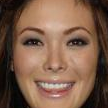

In [29]:
im = load_image(ims[0])
im

In [31]:
im.shape

(108, 108)

After testing a few more images, we can notice that many of them have dimensions below `128x128`. So, let's use fastai's `DataBlock` & `dataloaders` to load these images. `DataBlock` allows us to construct datasets with a lot of flexibility at each step. We'll see how:

In [89]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=partial(get_image_files, folders=['Train', 'Validation']),
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='Train', valid_name='Validation'),
    item_tfms=Resize(128),
)

Let's deconstruct what we did above:

- `blocks` tell what kind of datablock we're building... in this case, we want to do image classification. Hence, we load an image and assign a category to it.
- `get_items` tell how & where to look for our files. Since, we're dealing with images, we use `get_image_files`. We use `partial` (from `functools`) to fix the _folders_ attribute as we don't want to pick images from _test_ set as well.
- `get_y` provides _label_ for our classes. Each image should ideally be labelled `WithMask` or `WithoutMask`.
- `splitter` helps us split the dataset into _training & validation_ sets by separating images from `Train` & `Validation` folders
- `item_tfms` are the transformations (or a set of operations) that we perform on each item (in this case, an image) before we bunch them together as a batch. In this case, we are resizing all images to `128x128`.

Now, let's provide the source path of the images to finally load them with `dataloaders`.

In [90]:
dls = faces.dataloaders(path/'data/Face Mask Dataset/', bs=64)

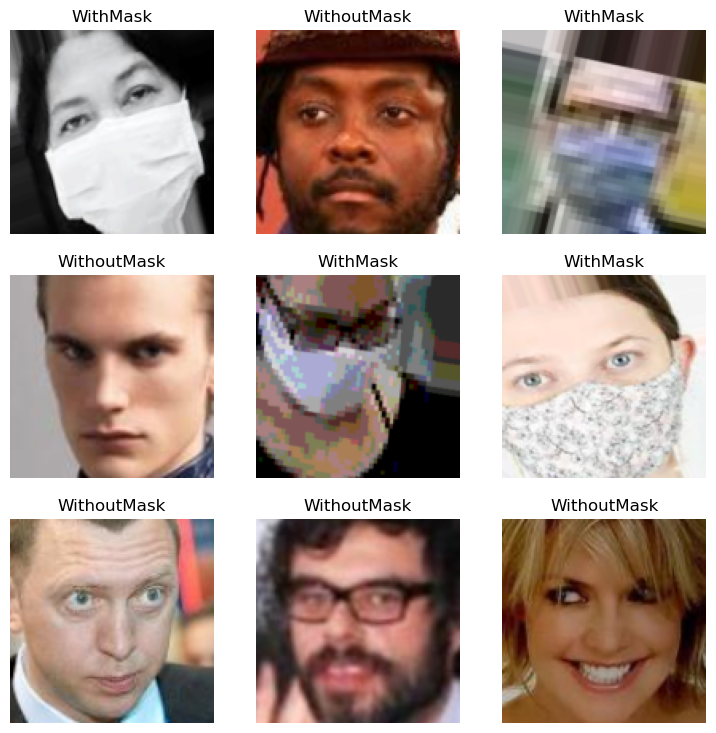

In [97]:
dls.train.show_batch()

We can check what classes our data falls under by looking at the `.c` attribute of our dataloaders object.

In [154]:
dls.c

2

and `.vocab` attribute tells what those classes and their order is!

In [155]:
dls.vocab

['WithMask', 'WithoutMask']

Looks good! Now let's train a model... we can start with a simple one like `resnet18` and use a more complex one if needed. We track our model's performance by monitoring its `accuracy`.

# Training a model

In [100]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
learner = vision_learner(dls, resnet18, metrics=accuracy)

::: {.callout-note}

if this is the first time you run the above command, it will download a pre-trained model onto the disk.

:::

SuggestedLRs(steep=0.0003981071640737355, minimum=0.02089296132326126, valley=0.0008317637839354575)

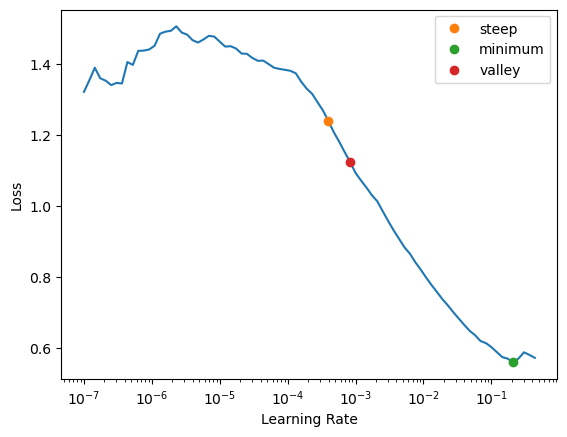

In [106]:
learner.lr_find(suggest_funcs=(steep, minimum, valley))

using the builtin _learning rate_ finder, it looks like a good value is `~5e-3`... let's train the model with that for `3` epochs!

In [107]:
learner.fine_tune(3, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.095269,0.025470,0.990000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.028186,0.016682,0.996250,00:16
1,0.011198,0.006065,0.997500,00:15
2,0.002301,0.001746,0.998750,00:15


Wow! a near `100%` accuracy! 🎉😍 _Fastai_ always ensures that the metrics are reported on the validation dataset, so that's a good sign. Let's see what the model learnt!

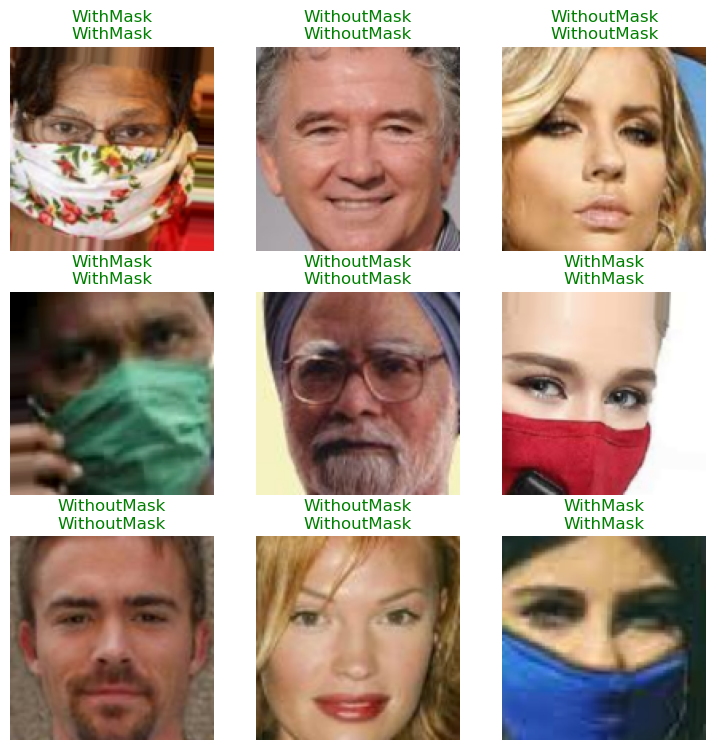

In [108]:
learner.show_results()

## verifying results

In [109]:
interp = ClassificationInterpretation.from_learner(learner)

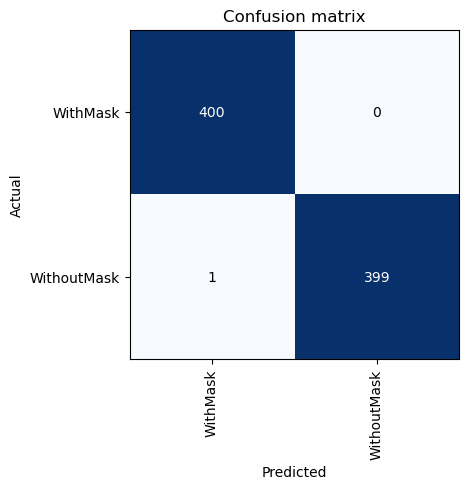

In [110]:
interp.plot_confusion_matrix()

Let's see what the model is getting wrong or is most unsure about by plotting its top losses!

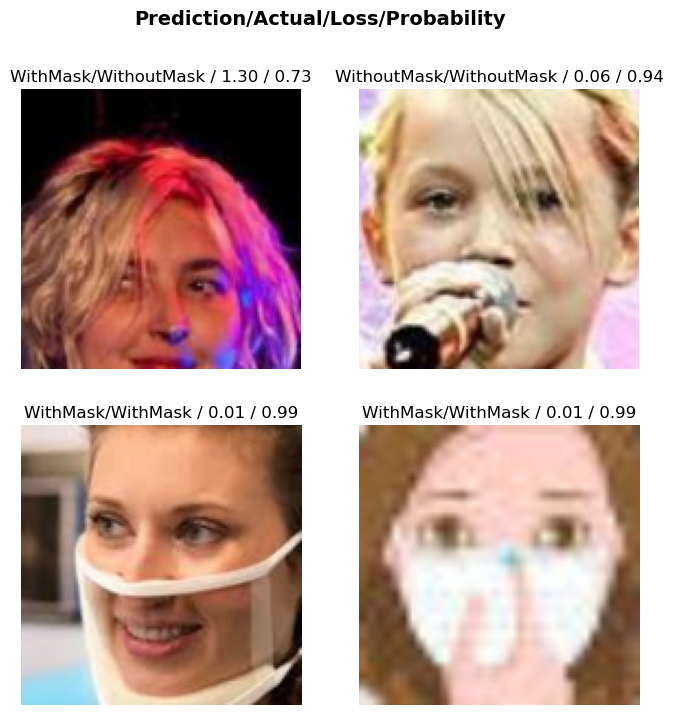

In [116]:
interp.plot_top_losses(4, figsize=(8, 8))

We only got one incorrect image & the rest are correct but a bit inconfident (and even that's low for the 2^nd^ row of images).

### Image Shifting

Let's do a bit of fun! Sometimes, it's known that some image recognition models predict completely different classes when even a few pixels are changed... hence let's see how robust our model is by rotating and wrapping an image and then letting our model predict.

In [170]:
def rotate_and_wrap_image(image, percentage=.4):
    im = tensor(image)
    val = int(im.shape[1] * percentage)
    return torch.cat((im[:, val:], im[:, :val]), dim=1)    

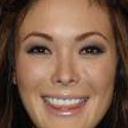

In [171]:
im.resize((128, 128))

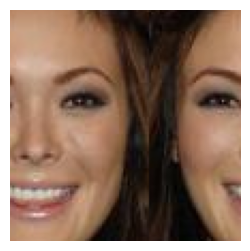

In [173]:
show_image(rotate_and_wrap_image(im));

In [174]:
learner.predict(rotate_and_wrap_image(im))

('WithoutMask', TensorBase(1), TensorBase([3.2003e-07, 1.0000e+00]))

interesting! our model still predicts correct class and this worked on many other tested images as well. This might mean that the model has actually learnt to identify a 😷 and not 'remember' the image itself.

# Predict on test set

Let's provide the test images to our model and see how well it predicts!

In [177]:
test_ims = get_image_files(path/'data/Face Mask Dataset/' , folders=['Test'])
test_ims

(#992) [Path('data/Face Mask Dataset/Test/WithoutMask/1940.png'),Path('data/Face Mask Dataset/Test/WithoutMask/1969.png'),Path('data/Face Mask Dataset/Test/WithoutMask/45.png'),Path('data/Face Mask Dataset/Test/WithoutMask/2497.png'),Path('data/Face Mask Dataset/Test/WithoutMask/807.png'),Path('data/Face Mask Dataset/Test/WithoutMask/3830.png'),Path('data/Face Mask Dataset/Test/WithoutMask/972.png'),Path('data/Face Mask Dataset/Test/WithoutMask/3825.png'),Path('data/Face Mask Dataset/Test/WithoutMask/4024.png'),Path('data/Face Mask Dataset/Test/WithoutMask/4178.png')...]

In [178]:
test_dl = learner.dls.test_dl(test_ims)

In [184]:
preds, _ = learner.get_preds(dl=test_dl)
preds.shape

torch.Size([992, 2])

In [213]:
preds[:5]

TensorBase([[4.3606e-05, 9.9996e-01],
            [3.7663e-07, 1.0000e+00],
            [2.5526e-06, 1.0000e+00],
            [3.0737e-10, 1.0000e+00],
            [1.1245e-08, 1.0000e+00]])

We got probabilities... we need to somehow use them to compare with the actual labels. First, let's get the actual labels.

We know from the `.vocab` attribute that class _0_ with `WithMask` and _1_ is `WithoutMask`. So let's extract the label from each test image based on which folder it's coming from.

In [214]:
test_ims[0]

Path('data/Face Mask Dataset/Test/WithoutMask/1940.png')

In [220]:
test_ims[0].parent

Path('data/Face Mask Dataset/Test/WithoutMask')

In [221]:
test_ims[0].parent.stem

'WithoutMask'

In [207]:
targets = test_ims.map(lambda x: 1 * (x.parent.stem == 'WithoutMask'))
targets

(#992) [1,1,1,1,1,1,1,1,1,1...]

In [209]:
preds.argmax(1).shape, len(targets)

(torch.Size([992]), 992)

Now we compare our predictions with the targets and take the average like so:

In [212]:
(preds.argmax(1) == tensor(targets)).float().mean()

TensorBase(0.9990)

Sweet! 💗

# Conclusion

We now know how to train a simple computer vision model to detect facemasks! However, we can't completely generalize and say that our model can be used in the actual real world! There are pitfalls and it is always important to understand the limitations of our models.

Always look at where the data is coming from. In this case, it is a bunch of google images and celebrity faces. All the images are cropped around the face. So our model might not predict well when given an unclipped full image of a person with/without a mask. It would still predict one of the two classes even when we submit a completely different image, say a 🦒. Also the image quality it was trained on is around `128x128` pixels, which is rather low.

We will possibly see how to address these issues in another post covering another dataset! Until then, 👋